# Introduction: 

Quantium is a data analytics and consulting company that specialises in using data to generate commercial insights for businesses, particularly in retail and consumer behaviour. In this project, Quantium provides transaction and customer data that allows us to analyse purchasing behaviour for chips across different customer segments.

Using this dataset, we can explore patterns such as total sales contribution by customer segment, purchasing frequency, brand preferences, and price sensitivity. The goal of this analysis is to identify key customer groups and behavioural trends that can support data-driven marketing and product decisions.

In [1]:
import pandas as pd
import matplotlib as plt
from scipy.stats import ttest_ind
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder 
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
pwd


'/Users/pracyaim'

In [3]:
chips = pd.read_excel('/Users/pracyaim/downloads/QVI_transaction_data.xlsx')
                      
beh = pd.read_csv('/Users/pracyaim/downloads/QVI_purchase_behaviour.csv')
                      
                                 

## 1. Exploratory data analysis

In [4]:


chips


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
...,...,...,...,...,...,...,...,...
264831,43533,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8
264832,43325,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4
264833,43410,272,272379,270187,51,Doritos Mexicana 170g,2,8.8
264834,43461,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8


In [5]:
beh

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream
...,...,...,...
72632,2370651,MIDAGE SINGLES/COUPLES,Mainstream
72633,2370701,YOUNG FAMILIES,Mainstream
72634,2370751,YOUNG FAMILIES,Premium
72635,2370961,OLDER FAMILIES,Budget


## 2. Examining transaction

In [6]:
### Examining transaction data types
beh.dtypes

LYLTY_CARD_NBR       int64
LIFESTAGE           object
PREMIUM_CUSTOMER    object
dtype: object

In [7]:
chips.dtypes

DATE                int64
STORE_NBR           int64
LYLTY_CARD_NBR      int64
TXN_ID              int64
PROD_NBR            int64
PROD_NAME          object
PROD_QTY            int64
TOT_SALES         float64
dtype: object

In [8]:
#Convert DATE to date format

chips["DATE"] = pd.to_datetime(chips["DATE"], unit="D", origin="1899-12-30")


In [9]:
#
chips["PROD_WEIGH"] = chips["PROD_NAME"].str.extract(
    r"(\d+\s*(?:g|G|kg|KG))"
)
chips["PROD_NAME"] = chips["PROD_NAME"].str.replace(
    r"\s*\d+\s*(?:g|G|kg|KG)", "", 
    regex=True
).str.strip()

In [10]:

# Remove 'g' or 'kg' and convert to float
chips['PROD_WEIGH_NUM'] = chips['PROD_WEIGH'].str.replace(r'[^\d.]', '', regex=True).astype(float)
chips['PROD_WEIGH_NUM'] 



0         175.0
1         175.0
2         170.0
3         175.0
4         150.0
          ...  
264831    175.0
264832    175.0
264833    170.0
264834    150.0
264835    175.0
Name: PROD_WEIGH_NUM, Length: 264836, dtype: float64

In [11]:
# Split product names into individual words
chips["WORDS"] = chips["PROD_NAME"].str.split()




chips["PROD_NAME"] = chips["WORDS"].apply(
    lambda words: [w for w in words if re.match(r"^[A-Za-z]+$", w)]
)

In [12]:
chips[["PROD_NAME", "WORDS"]].head(5)

,PROD_NAME,WORDS
0,"[Natural, Chip, Compny, SeaSalt]","[Natural, Chip, Compny, SeaSalt]"
1,"[CCs, Nacho, Cheese]","[CCs, Nacho, Cheese]"
2,"[Smiths, Crinkle, Cut, Chips, Chicken]","[Smiths, Crinkle, Cut, Chips, Chicken]"
3,"[Smiths, Chip, Thinly]","[Smiths, Chip, Thinly, S/Cream&Onion]"
4,"[Kettle, Tortilla, Chili]","[Kettle, Tortilla, ChpsHny&Jlpno, Chili]"


In [13]:
 
# Flatten all words and count most common
from collections import Counter

all_words = [w for words in chips["PROD_NAME"] for w in words]
word_counts = Counter(all_words)
word_counts.most_common(20)


[('Chips', 49770),
 ('Kettle', 41288),
 ('Smiths', 28860),
 ('Salt', 27976),
 ('Cheese', 27890),
 ('Pringles', 25102),
 ('Doritos', 24962),
 ('Crinkle', 23960),
 ('Corn', 22063),
 ('Original', 21560),
 ('Cut', 20754),
 ('Chip', 18645),
 ('Chicken', 18577),
 ('Salsa', 18094),
 ('Sea', 14145),
 ('Thins', 14075),
 ('Sour', 13882),
 ('Crisps', 12607),
 ('Vinegar', 12402),
 ('Chilli', 12389)]

In [14]:
# Keep only rows that do NOT contain "Salsa"
chips = chips[
    ~(
        chips["PROD_NAME"].str.contains("Salsa", case=False, na=False) |
        chips["WORDS"].apply(lambda words: any(w.lower() == "salsa" for w in words) if isinstance(words, list) else False)
    )
].reset_index(drop=True)


In [15]:
# Count on null values in each column
chips.isna().sum()


DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
PROD_WEIGH        0
PROD_WEIGH_NUM    0
WORDS             0
dtype: int64

In [16]:
# Summary statistics for numeric columns
chips.describe()  # mean, min, max, std, quartiles



,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES,PROD_WEIGH_NUM
count,246742,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742.000000,246742.000000,246742.000000
mean,2018-12-30 01:19:01.211467520,135.051098,1.355310e+05,1.351311e+05,56.351789,1.908062,7.321322,175.585178
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000,70.000000
25%,2018-09-30 00:00:00,70.000000,7.001500e+04,6.756925e+04,26.000000,2.000000,5.800000,150.000000
50%,2018-12-30 00:00:00,130.000000,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000,170.000000
75%,2019-03-31 00:00:00,203.000000,2.030840e+05,2.026538e+05,87.000000,2.000000,8.800000,175.000000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000,380.000000
std,NaN,76.787096,8.071528e+04,7.814772e+04,33.695428,0.659831,3.077828,59.434727


### Product quantity appears to have  outliers


In [17]:
# Find the transaction(s) where 200 bags were bought
outlier_qty = chips[chips["PROD_QTY"] == 200]

outlier_qty



,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_WEIGH,PROD_WEIGH_NUM,WORDS
64955,2018-08-19,226,226000,226201,4,"[Dorito, Corn, Chp, Supreme]",200,650.0,380g,380.0,"[Dorito, Corn, Chp, Supreme]"
64956,2019-05-20,226,226000,226210,4,"[Dorito, Corn, Chp, Supreme]",200,650.0,380g,380.0,"[Dorito, Corn, Chp, Supreme]"


There are two transactions where 200 packets of chips are bought in one transaction and both of these
transactions where by the same customer.

In [18]:
#  Let's see if the customer has had other transactions
customer_transactions = chips[chips["LYLTY_CARD_NBR"] == 226000]

# Display the transactions
customer_transactions

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_WEIGH,PROD_WEIGH_NUM,WORDS
64955,2018-08-19,226,226000,226201,4,"[Dorito, Corn, Chp, Supreme]",200,650.0,380g,380.0,"[Dorito, Corn, Chp, Supreme]"
64956,2019-05-20,226,226000,226210,4,"[Dorito, Corn, Chp, Supreme]",200,650.0,380g,380.0,"[Dorito, Corn, Chp, Supreme]"


It looks like this customer has only had the two transactions over the year and is not an ordinary retail
customer. The customer might be buying chips for commercial purposes instead. We’ll remove this loyalty
card number from further analysis

In [19]:
chips= chips.loc[chips['LYLTY_CARD_NBR']!= 226000]
chips.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES,PROD_WEIGH_NUM
count,246740,246740.000000,2.467400e+05,2.467400e+05,246740.000000,246740.000000,246740.000000,246740.000000
mean,2018-12-30 01:18:58.448569344,135.050361,1.355303e+05,1.351304e+05,56.352213,1.906456,7.316113,175.583521
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000,70.000000
25%,2018-09-30 00:00:00,70.000000,7.001500e+04,6.756875e+04,26.000000,2.000000,5.800000,150.000000
50%,2018-12-30 00:00:00,130.000000,1.303670e+05,1.351815e+05,53.000000,2.000000,7.400000,170.000000
75%,2019-03-31 00:00:00,203.000000,2.030832e+05,2.026522e+05,87.000000,2.000000,8.800000,175.000000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,5.000000,29.500000,380.000000
std,NaN,76.786971,8.071520e+04,7.814760e+04,33.695235,0.342499,2.474897,59.432118


In [20]:
# Count transactions per date
txn_count_by_date = (
    chips.groupby('DATE')['TXN_ID']
         .count()
         .reset_index()
         .sort_values('TXN_ID')
)

# Rename columns
txn_count_by_date.columns = ['DATE', 'Transaction_Count']

# Display
txn_count_by_date

,DATE,Transaction_Count
346,2019-06-13,607
83,2018-09-22,609
147,2018-11-25,610
109,2018-10-18,611
357,2019-06-24,612
...,...,...
172,2018-12-20,808
171,2018-12-19,839
174,2018-12-22,840
175,2018-12-23,853


There’s only 364 rows, meaning only 364 dates which indicates a missing date. Let’s create a sequence of
dates from 1 Jul 2018 to 30 Jun 2019 and use this to create a chart of number of transactions over time to
find the missing date.

Missing dates for Store 226:
          DATE  Transaction_Count
177 2018-12-25                0.0


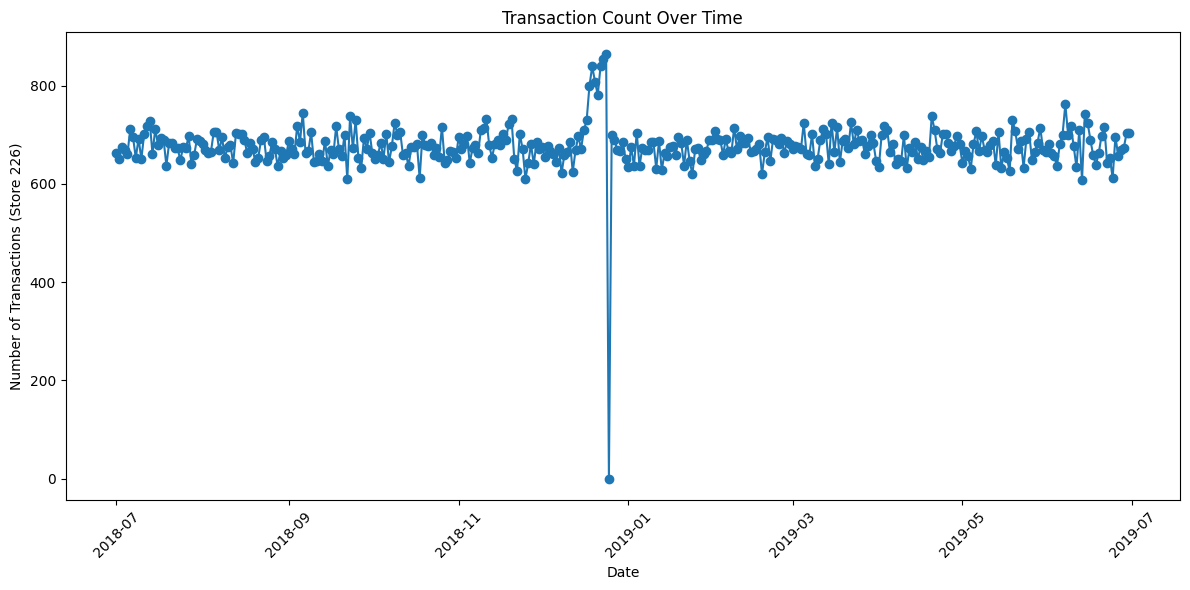

In [21]:
# Ploting to check  if any other transaction occured in the stores


#  Create a complete date range
all_dates = pd.date_range(start='2018-07-01', end='2019-06-30')

#  Count transactions per date
txn_count_by_date = chips.groupby('DATE')['TXN_ID'].count().reset_index()
txn_count_by_date.columns = ['DATE', 'Transaction_Count']

#  Merge with full date range
full_txn_df = pd.DataFrame({'DATE': all_dates})
full_txn_df = full_txn_df.merge(txn_count_by_date, on='DATE', how='left')

# Fill missing counts with 0
full_txn_df['Transaction_Count'] = full_txn_df['Transaction_Count'].fillna(0)

# Find missing dates for Store 226
missing_dates = full_txn_df[full_txn_df['Transaction_Count'] == 0]
print("Missing dates for Store 226:")
print(missing_dates)

# Plot transactions over time for Store 226
plt.figure(figsize=(12,6))
plt.plot(full_txn_df['DATE'], full_txn_df['Transaction_Count'], marker='o')

plt.xlabel("Date")
plt.ylabel("Number of Transactions (Store 226)")
plt.title("Transaction Count Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


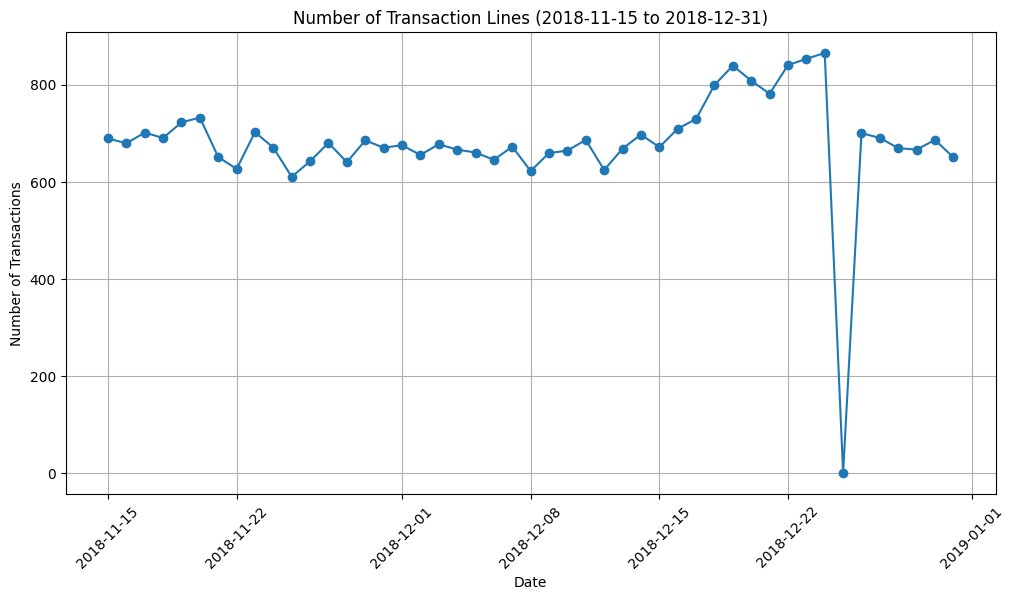

In [22]:

# Zoom in to identify the relevant range around the missing date

zoom_start = '2018-11-15'
zoom_end = '2018-12-31'

# Filtering the full transaction dataframe
zoom_txn_df = full_txn_df[(full_txn_df['DATE'] >= zoom_start) & (full_txn_df['DATE'] <= zoom_end)]

#  zoomed-in transactions
plt.figure(figsize=(12,6))
plt.plot(zoom_txn_df['DATE'], zoom_txn_df['Transaction_Count'], marker='o', linestyle='-')
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.title(f"Number of Transaction Lines ({zoom_start} to {zoom_end})")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

There is an increase in purchases in December and a break in late December.

In [23]:
# Compute total sales 
sales_by_date = chips.groupby("DATE")["TOT_SALES"].sum().reset_index()

# Sort descending
sales_sorted = sales_by_date.sort_values("TOT_SALES", ascending=False)

# Extract 1st, 2nd, 3rd highest
first  = sales_sorted.iloc[0]
second = sales_sorted.iloc[1]
third  = sales_sorted.iloc[2]

print("🏆 Highest Sales :")
print(f"1st  Highest: {first['DATE'].date()}  —  ${first['TOT_SALES']:.2f}")
print(f"2nd Highest: {second['DATE'].date()} —  ${second['TOT_SALES']:.2f}")
print(f"3rd Highest: {third['DATE'].date()}  —  ${third['TOT_SALES']:.2f}")


🏆 Highest Sales :
1st  Highest: 2018-12-24  —  $6410.90
2nd Highest: 2018-12-23 —  $6372.10
3rd Highest: 2018-12-19  —  $6164.70


### We can see that the increase in sales occurs in the lead-up to Christmas and that there are zero sales on Christmas day itself. This is due to shops being closed on Christmas day.


In [24]:
# Extracting chips weights

chips['PROD_WEIGH_NUM'].unique()

array([175., 170., 150., 330., 210., 270., 220., 125., 110., 134., 380.,
       180., 165., 135., 250., 200., 160., 190.,  90.,  70.])

### The largest size is 380g and the smallest size is 70g 

In [25]:
#Frequency

pack_size_freq_by_popularity = chips['PROD_WEIGH_NUM'].value_counts().sort_values(ascending=False)
print(pack_size_freq_by_popularity)


PROD_WEIGH_NUM
175.0    66390
150.0    40203
134.0    25102
110.0    22387
170.0    19983
165.0    15297
330.0    12540
380.0     6416
270.0     6285
210.0     6272
200.0     4473
135.0     3257
250.0     3169
90.0      3008
190.0     2995
160.0     2970
220.0     1564
70.0      1507
180.0     1468
125.0     1454
Name: count, dtype: int64


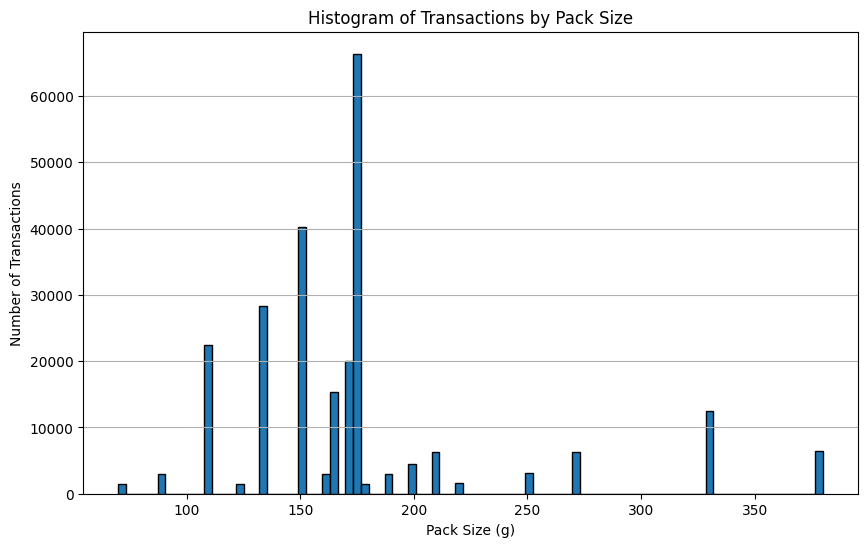

In [26]:

# Visualising transactions by pack size
plt.figure(figsize=(10,6))
plt.hist(chips['PROD_WEIGH_NUM'], bins=90, edgecolor='black')  # adjust bins as needed
plt.xlabel("Pack Size (g)")
plt.ylabel("Number of Transactions")
plt.title("Histogram of Transactions by Pack Size")
plt.grid(axis='y')
plt.show()


In [27]:
# Extracting brand from the first word
chips['PROD_NAME_STR'] = chips['PROD_NAME'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

chips['BRAND'] = chips['PROD_NAME_STR'].str.split().str[0]

chips[['PROD_NAME_STR', 'BRAND']]


,PROD_NAME_STR,BRAND
0,Natural Chip Compny SeaSalt,Natural
1,CCs Nacho Cheese,CCs
2,Smiths Crinkle Cut Chips Chicken,Smiths
3,Smiths Chip Thinly,Smiths
4,Kettle Tortilla Chili,Kettle
...,...,...
246737,Kettle Sweet Chilli And Sour Cream,Kettle
246738,Tostitos Splash Of Lime,Tostitos
246739,Doritos Mexicana,Doritos
246740,Doritos Corn Chip Mexican Jalapeno,Doritos


In [28]:
N = chips['BRAND'].value_counts().sort_values(ascending=False)
N

BRAND
Kettle        41288
Smiths        27390
Pringles      25102
Doritos       22041
Thins         14075
RRD           11894
Infuzions     11057
WW            10320
Cobs           9693
Tostitos       9471
Twisties       9454
Tyrrells       6442
Grain          6272
Natural        6050
Cheezels       4603
CCs            4551
Red            4427
Dorito         3183
Infzns         3144
Smith          2963
Cheetos        2927
Snbts          1576
Burger         1564
Woolworths     1516
GrnWves        1468
Sunbites       1432
NCC            1419
French         1418
Name: count, dtype: int64

In [29]:
# Combining mistaken brands together
chips['BRAND'] = chips['BRAND'].replace({
    'RRD': 'RED', 
    'Red':'RED',     
    'Snbts': 'Sunbites',
    'Dorito':'Doritos',
    'Infzns':'Infuzions',
    'WW': 'Woolworths', 
    'Smith': "Smiths",
    'NCC': 'Natural', 
    'GrnWves':'Grain'
   
})



In [30]:
# Checking number brands again
N = chips['BRAND'].sort_values(ascending = False).value_counts()
N

BRAND
Kettle        41288
Smiths        30353
Doritos       25224
Pringles      25102
RED           16321
Infuzions     14201
Thins         14075
Woolworths    11836
Cobs           9693
Tostitos       9471
Twisties       9454
Grain          7740
Natural        7469
Tyrrells       6442
Cheezels       4603
CCs            4551
Sunbites       3008
Cheetos        2927
Burger         1564
French         1418
Name: count, dtype: int64

1. Best-selling products

chip flavours drive the most revenue:Dorito Corn Chips – Supreme

product sizes sell the most: 175g bags

2. High-value customer segments

Which lifestage group buys the most: OLDER SINGLES/COUPLES

Whether Premium, Mainstream, or Budget has higher sales: Mainstream

Which combination (e.g., "Older Families – Mainstream") dominates sales: OLDER FAMILIES – Budget

3. Drivers of Quantity

High PROD_QTY purchases (multiple bags per transaction)


4. Store with highest Sales: 226

Top-selling products in Store 226 :4

Customer segment mix for Store 226: 

Quantity differences compared to other stores: 

Most weight bought: 175g  by 66,390

Popular Brand: Kettle with 390,239.8

## Examining customer data

In [31]:
beh

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream
...,...,...,...
72632,2370651,MIDAGE SINGLES/COUPLES,Mainstream
72633,2370701,YOUNG FAMILIES,Mainstream
72634,2370751,YOUNG FAMILIES,Premium
72635,2370961,OLDER FAMILIES,Budget


In [32]:
beh.describe()

,LYLTY_CARD_NBR
count,7.263700e+04
mean,1.361859e+05
std,8.989293e+04
min,1.000000e+03
25%,6.620200e+04
50%,1.340400e+05
75%,2.033750e+05
max,2.373711e+06


In [33]:
#### Examining the values of lifestage

beh['LIFESTAGE'].value_counts()

LIFESTAGE
RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9780
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
Name: count, dtype: int64

In [34]:
#### Examining the values of premium_customer

beh['PREMIUM_CUSTOMER'].value_counts()

PREMIUM_CUSTOMER
Mainstream    29245
Budget        24470
Premium       18922
Name: count, dtype: int64

As the number of rows in data is the same as that of transactionData, we can be sure that no duplicates
were created. This is because we created data by setting all.x = TRUE (in other words, a left join) which
means take all the rows in transactionData and find rows with matching values in shared columns and
then joining the details in these rows to the x or the first mentioned table.


In [35]:

merged_df = chips.merge(beh, on="LYLTY_CARD_NBR", how="left")
merged_df

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_WEIGH,PROD_WEIGH_NUM,WORDS,PROD_NAME_STR,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,"[Natural, Chip, Compny, SeaSalt]",2,6.0,175g,175.0,"[Natural, Chip, Compny, SeaSalt]",Natural Chip Compny SeaSalt,Natural,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,"[CCs, Nacho, Cheese]",3,6.3,175g,175.0,"[CCs, Nacho, Cheese]",CCs Nacho Cheese,CCs,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,"[Smiths, Crinkle, Cut, Chips, Chicken]",2,2.9,170g,170.0,"[Smiths, Crinkle, Cut, Chips, Chicken]",Smiths Crinkle Cut Chips Chicken,Smiths,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,"[Smiths, Chip, Thinly]",5,15.0,175g,175.0,"[Smiths, Chip, Thinly, S/Cream&Onion]",Smiths Chip Thinly,Smiths,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,"[Kettle, Tortilla, Chili]",3,13.8,150g,150.0,"[Kettle, Tortilla, ChpsHny&Jlpno, Chili]",Kettle Tortilla Chili,Kettle,MIDAGE SINGLES/COUPLES,Budget
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246735,2019-03-09,272,272319,270088,89,"[Kettle, Sweet, Chilli, And, Sour, Cream]",2,10.8,175g,175.0,"[Kettle, Sweet, Chilli, And, Sour, Cream]",Kettle Sweet Chilli And Sour Cream,Kettle,YOUNG SINGLES/COUPLES,Premium
246736,2018-08-13,272,272358,270154,74,"[Tostitos, Splash, Of, Lime]",1,4.4,175g,175.0,"[Tostitos, Splash, Of, Lime]",Tostitos Splash Of Lime,Tostitos,YOUNG SINGLES/COUPLES,Premium
246737,2018-11-06,272,272379,270187,51,"[Doritos, Mexicana]",2,8.8,170g,170.0,"[Doritos, Mexicana]",Doritos Mexicana,Doritos,YOUNG SINGLES/COUPLES,Premium
246738,2018-12-27,272,272379,270188,42,"[Doritos, Corn, Chip, Mexican, Jalapeno]",2,7.8,150g,150.0,"[Doritos, Corn, Chip, Mexican, Jalapeno]",Doritos Corn Chip Mexican Jalapeno,Doritos,YOUNG SINGLES/COUPLES,Premium


In [36]:
beh_cols = [col for col in beh.columns if col != "LYLTY_CARD_NBR"]

# Count rows where ANY behavioural field is NaN
nan_rows = merged_df[beh_cols].isna().any(axis=1).sum()

print("Number of transactions with missing behavioural data:", nan_rows)


Number of transactions with missing behavioural data: 0


In [37]:
merged_df[beh_cols].isna().sum()


LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

## 3. Data analysis on customer segments

In [38]:
#Total sales per customer, grouped by segment

# Aggregate by customer, lifestage, and premium status
customer_sales = merged_df.groupby(
    ['LYLTY_CARD_NBR', 'LIFESTAGE', 'PREMIUM_CUSTOMER']
).agg(
    total_chips_sales = ('TOT_SALES', 'sum'),
    total_chips_qty   = ('PROD_QTY', 'sum')
).reset_index()

# Sort by highest total sales
top_spenders = customer_sales.sort_values('total_chips_sales', ascending=False)
top_spenders


,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,total_chips_sales,total_chips_qty
59820,230078,OLDER FAMILIES,Budget,138.6,36
15646,58361,YOUNG FAMILIES,Budget,124.8,28
16928,63197,OLDER FAMILIES,Budget,122.6,30
42037,162039,OLDER FAMILIES,Mainstream,121.6,34
47076,179228,YOUNG FAMILIES,Budget,120.8,32
...,...,...,...,...,...
20089,74339,OLDER SINGLES/COUPLES,Budget,1.7,1
31863,120143,YOUNG SINGLES/COUPLES,Budget,1.7,1
4645,18102,YOUNG SINGLES/COUPLES,Mainstream,1.7,1
20085,74329,OLDER SINGLES/COUPLES,Mainstream,1.7,1


Sales are coming mainly from Budget - older families

In [39]:
# Number of customers in each segment
segment_counts = customer_sales.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique().sort_values( ascending= False)
segment_counts


LIFESTAGE               PREMIUM_CUSTOMER
YOUNG SINGLES/COUPLES   Mainstream          7917
RETIREES                Mainstream          6358
OLDER SINGLES/COUPLES   Mainstream          4858
                        Budget              4849
                        Premium             4682
OLDER FAMILIES          Budget              4611
RETIREES                Budget              4385
YOUNG FAMILIES          Budget              3953
RETIREES                Premium             3812
YOUNG SINGLES/COUPLES   Budget              3647
MIDAGE SINGLES/COUPLES  Mainstream          3298
OLDER FAMILIES          Mainstream          2788
YOUNG FAMILIES          Mainstream          2685
YOUNG SINGLES/COUPLES   Premium             2480
YOUNG FAMILIES          Premium             2398
MIDAGE SINGLES/COUPLES  Premium             2369
OLDER FAMILIES          Premium             2231
MIDAGE SINGLES/COUPLES  Budget              1474
NEW FAMILIES            Budget              1087
                        Main

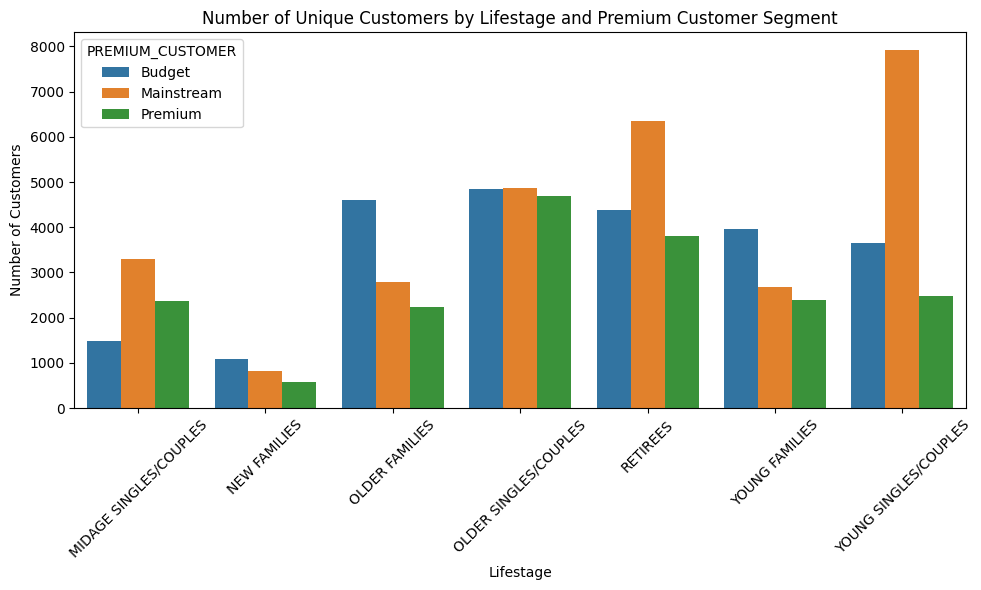

In [40]:


# Count unique customers by LIFESTAGE and PREMIUM_CUSTOMER
customer_count = merged_df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'] \
                          .nunique().reset_index()
customer_count.rename(columns={'LYLTY_CARD_NBR': 'Num_Customers'}, inplace=True)

# Plot number of customers by segment
plt.figure(figsize=(10,6))
sns.barplot(
    data=customer_count,
    x='LIFESTAGE',
    y='Num_Customers',
    hue='PREMIUM_CUSTOMER'
)
plt.xticks(rotation=45)
plt.title("Number of Unique Customers by Lifestage and Premium Customer Segment")
plt.ylabel("Number of Customers")
plt.xlabel("Lifestage")
plt.tight_layout()
plt.show()


In [41]:
# Average chips bought per customer by segment

avg_qty_per_segment = customer_sales.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['total_chips_qty'].mean().sort_values( ascending= False)
avg_qty_per_segment


LIFESTAGE               PREMIUM_CUSTOMER
OLDER FAMILIES          Mainstream          9.255380
                        Budget              9.076773
                        Premium             9.071717
YOUNG FAMILIES          Budget              8.722995
                        Premium             8.716013
                        Mainstream          8.638361
OLDER SINGLES/COUPLES   Budget              6.781398
                        Premium             6.769543
                        Mainstream          6.712021
MIDAGE SINGLES/COUPLES  Mainstream          6.432080
RETIREES                Budget              6.141847
                        Premium             6.103358
MIDAGE SINGLES/COUPLES  Premium             6.078514
                        Budget              6.026459
RETIREES                Mainstream          5.925920
NEW FAMILIES            Mainstream          4.891566
                        Budget              4.821527
                        Premium             4.815652
YOUNG

Older families and young families in general buy more chips per customer

In [42]:
# Average price per chip = total sales / total quantity
customer_sales['avg_chip_price'] = customer_sales['total_chips_sales'] / customer_sales['total_chips_qty']

avg_price_per_segment = customer_sales.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['avg_chip_price'].mean().sort_values(ascending=False)
avg_price_per_segment


LIFESTAGE               PREMIUM_CUSTOMER
YOUNG SINGLES/COUPLES   Mainstream          4.128781
MIDAGE SINGLES/COUPLES  Mainstream          4.063488
RETIREES                Budget              3.960490
                        Premium             3.959497
OLDER SINGLES/COUPLES   Premium             3.935973
                        Budget              3.902976
NEW FAMILIES            Mainstream          3.898040
                        Budget              3.891710
                        Premium             3.859990
RETIREES                Mainstream          3.839393
YOUNG FAMILIES          Budget              3.833669
                        Premium             3.833642
OLDER FAMILIES          Budget              3.816112
OLDER SINGLES/COUPLES   Mainstream          3.814284
OLDER FAMILIES          Mainstream          3.813291
YOUNG FAMILIES          Mainstream          3.796621
OLDER FAMILIES          Premium             3.785839
MIDAGE SINGLES/COUPLES  Premium             3.772121
     

/var/folders/2y/4l86jv4d5839q8pz_dv0lqq40000gn/T/ipykernel_10830/2445572496.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_df


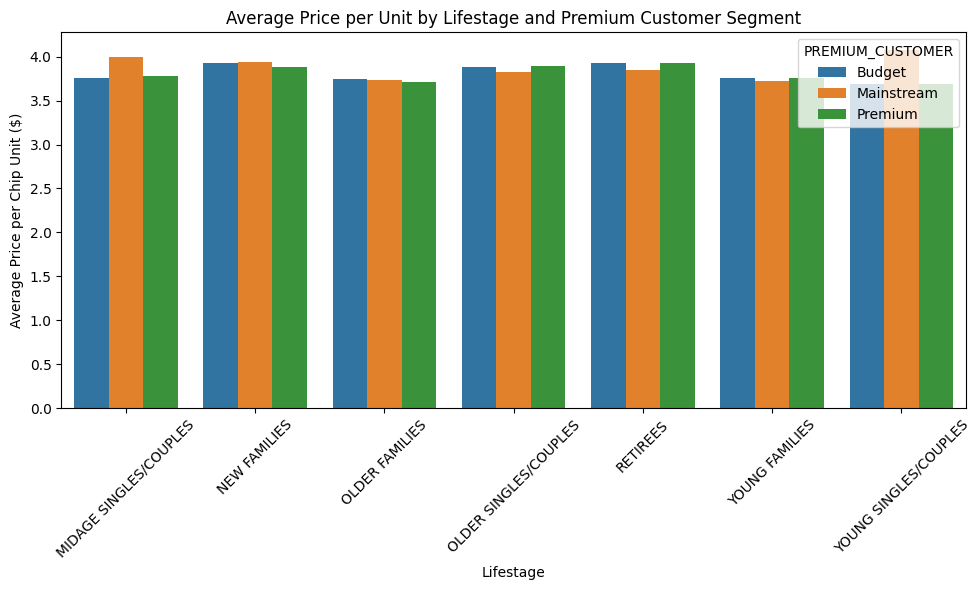

In [43]:
# Calculate average price per chip unit by LIFESTAGE and PREMIUM_CUSTOMER
avg_price_segment = (
    merged_df
    .groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'], group_keys=False)
    .apply(lambda x: x['TOT_SALES'].sum() / x['PROD_QTY'].sum())
    .reset_index(name='Avg_Unit_Price')
)

# Plot the average price per unit by segment
plt.figure(figsize=(10,6))
sns.barplot(
    data=avg_price_segment,
    x='LIFESTAGE',
    y='Avg_Unit_Price',
    hue='PREMIUM_CUSTOMER'
)
plt.xticks(rotation=45)
plt.title("Average Price per Unit by Lifestage and Premium Customer Segment")
plt.ylabel("Average Price per Chip Unit ($)")
plt.xlabel("Lifestage")
plt.tight_layout()
plt.show()


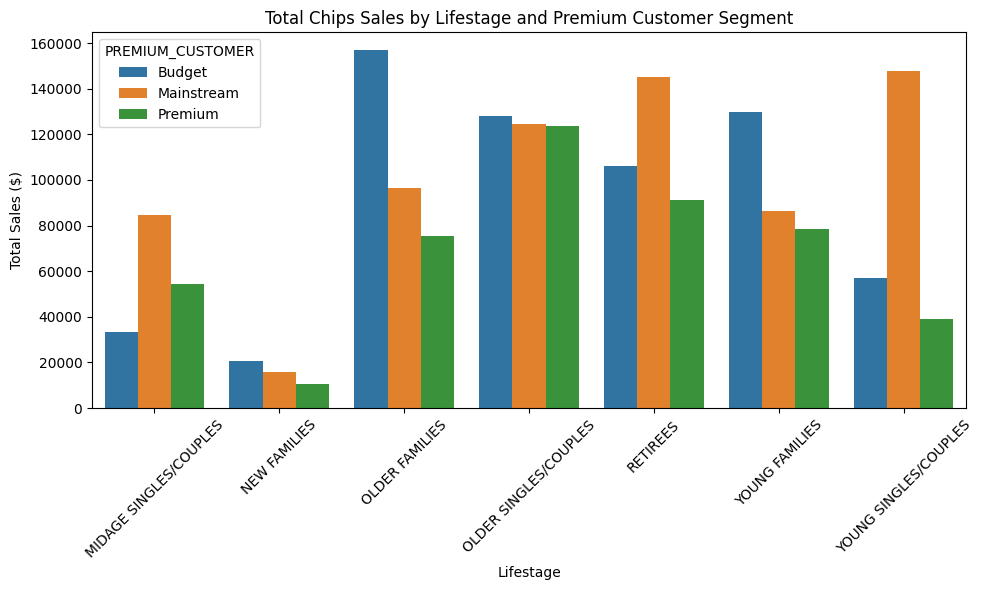

In [68]:
# Total sales by LIFESTAGE and PREMIUM_CUSTOMER graph

sales_summary = merged_df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()

# Plot total sales
plt.figure(figsize=(10,6))
sns.barplot(
    data=sales_summary,
    x='LIFESTAGE',
    y='TOT_SALES',
    hue='PREMIUM_CUSTOMER'
)
plt.xticks(rotation=45)
plt.title("Total Chips Sales by Lifestage and Premium Customer Segment")
plt.ylabel("Total Sales ($)")
plt.xlabel("Lifestage")
plt.tight_layout()
plt.show()


YOUNG SINGLES/COUPLES - Mainstream and MIDAGE SINGLES/COUPLES - Mainstream and Older Families - Bugdet  tend to buy expensinve chips, this may be because they buy healthier types

In [45]:
segment_summary = customer_sales.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg(
    num_customers = ('LYLTY_CARD_NBR', 'nunique'),
    avg_chips_bought = ('total_chips_qty', 'mean'),
    avg_chip_price   = ('avg_chip_price', 'mean')
).reset_index().sort_values( 'num_customers',ascending= False)

segment_summary


,LIFESTAGE,PREMIUM_CUSTOMER,num_customers,avg_chips_bought,avg_chip_price
19,YOUNG SINGLES/COUPLES,Mainstream,7917,4.575597,4.128781
13,RETIREES,Mainstream,6358,5.925920,3.839393
10,OLDER SINGLES/COUPLES,Mainstream,4858,6.712021,3.814284
9,OLDER SINGLES/COUPLES,Budget,4849,6.781398,3.902976
11,OLDER SINGLES/COUPLES,Premium,4682,6.769543,3.935973
6,OLDER FAMILIES,Budget,4611,9.076773,3.816112
12,RETIREES,Budget,4385,6.141847,3.960490
15,YOUNG FAMILIES,Budget,3953,8.722995,3.833669
14,RETIREES,Premium,3812,6.103358,3.959497
18,YOUNG SINGLES/COUPLES,Budget,3647,4.250069,3.617723


Older families and young families in general buy more chips per customer
Let's also investigate the average price per unit chips bought for each customer
segment as this is also a driver of total sales.


In [46]:
# Filter for the customer segments of interest
segments = merged_df[
    merged_df['LIFESTAGE'].isin(['MIDAGE SINGLES/COUPLES', 'YOUNG SINGLES/COUPLES'])
]

# Mainstream vs Premium/Budget
mainstream = segments[segments['PREMIUM_CUSTOMER'] == 'Mainstream']['TOT_SALES'] / segments[segments['PREMIUM_CUSTOMER'] == 'Mainstream']['PROD_QTY']
premium_budget = segments[segments['PREMIUM_CUSTOMER'].isin(['Premium','Budget'])]['TOT_SALES'] / segments[segments['PREMIUM_CUSTOMER'].isin(['Premium','Budget'])]['PROD_QTY']

t_stat, p_value = ttest_ind(mainstream, premium_budget, equal_var=False)  # Welch's t-test
print("t-statistic:", t_stat)
print("p-value:", p_value)

    

t-statistic: 37.6243885962295
p-value: 6.967354233018139e-306


#### The t-test results in a p <0.001, indicating that the average unit price for mainstream, young and mid-age singles and couples is significantly higher than that of budget and premium customers in the same lifestages.

In [47]:
# Mainstream - young singles/couples
target_segment = merged_df[
    (merged_df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') &
    (merged_df['PREMIUM_CUSTOMER'] == 'Mainstream')
].copy()



In [48]:
# Count number of transactions by brand for this segment
brand_counts = target_segment['BRAND'].value_counts().sort_values(ascending=False)
print("Top brands for Mainstream young singles/couples:")
print(brand_counts.head(10))



Top brands for Mainstream young singles/couples:
BRAND
Kettle       3844
Doritos      2379
Pringles     2315
Smiths       1921
Infuzions    1250
Thins        1166
Twisties      900
Tostitos      890
RED           875
Cobs          864
Name: count, dtype: int64


In [49]:
target_segment

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_WEIGH,PROD_WEIGH_NUM,WORDS,PROD_NAME_STR,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
221345,2018-08-16,1,1020,26,19,"[Smiths, Crinkle, Cut]",1,2.6,150g,150.0,"[Smiths, Crinkle, Cut, Snag&Sauce]",Smiths Crinkle Cut,Smiths,YOUNG SINGLES/COUPLES,Mainstream
221346,2018-08-17,1,1163,188,46,"[Kettle, Original]",1,5.4,175g,175.0,"[Kettle, Original]",Kettle Original,Kettle,YOUNG SINGLES/COUPLES,Mainstream
221347,2018-08-14,1,1291,333,27,"[WW, Supreme, Cheese, Corn, Chips]",1,1.9,200g,200.0,"[WW, Supreme, Cheese, Corn, Chips]",WW Supreme Cheese Corn Chips,Woolworths,YOUNG SINGLES/COUPLES,Mainstream
221348,2019-05-15,3,3031,1227,14,"[Smiths, Crnkle, Chip, Orgnl, Big, Bag]",1,5.9,380g,380.0,"[Smiths, Crnkle, Chip, Orgnl, Big, Bag]",Smiths Crnkle Chip Orgnl Big Bag,Smiths,YOUNG SINGLES/COUPLES,Mainstream
221349,2019-05-18,3,3118,1574,62,"[Pringles, Mystery, Flavour]",1,3.7,134g,134.0,"[Pringles, Mystery, Flavour]",Pringles Mystery Flavour,Pringles,YOUNG SINGLES/COUPLES,Mainstream
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240884,2018-12-01,272,272377,270186,75,"[Cobs, Popd, Sea, Salt, Chips]",2,7.6,110g,110.0,"[Cobs, Popd, Sea, Salt, Chips]",Cobs Popd Sea Salt Chips,Cobs,YOUNG SINGLES/COUPLES,Mainstream
240885,2018-07-27,272,272389,270200,114,"[Kettle, Sensations, Siracha, Lime]",2,9.2,150g,150.0,"[Kettle, Sensations, Siracha, Lime]",Kettle Sensations Siracha Lime,Kettle,YOUNG SINGLES/COUPLES,Mainstream
240886,2018-11-10,272,272389,270201,26,"[Pringles, BBQ]",2,7.4,134g,134.0,"[Pringles, Sweet&Spcy, BBQ]",Pringles BBQ,Pringles,YOUNG SINGLES/COUPLES,Mainstream
240887,2019-04-01,272,272389,270202,62,"[Pringles, Mystery, Flavour]",2,7.4,134g,134.0,"[Pringles, Mystery, Flavour]",Pringles Mystery Flavour,Pringles,YOUNG SINGLES/COUPLES,Mainstream


In [50]:
# Group by Order ID and aggregate Product subcategories into lists

basket = target_segment.groupby("LYLTY_CARD_NBR")["BRAND"].apply(list
                                                                )

In [51]:
basket

LYLTY_CARD_NBR
1002                               [RED]
1010                           [Doritos]
1018            [Kettle, RED, Infuzions]
1020             [Smiths, Smiths, Grain]
1060       [Tyrrells, Twisties, Doritos]
                       ...              
272391                          [Kettle]
2330041                          [Grain]
2330321                       [Twisties]
2370181                         [Kettle]
2373711                         [Smiths]
Name: BRAND, Length: 7917, dtype: object

In [52]:
te = TransactionEncoder()
te_ary = te.fit(basket).transform(basket)
basket_df=pd.DataFrame(te_ary,columns=te.columns_)
basket_df

,Burger,CCs,Cheetos,Cheezels,Cobs,Doritos,French,Grain,Infuzions,Kettle,Natural,Pringles,RED,Smiths,Sunbites,Thins,Tostitos,Twisties,Tyrrells,Woolworths
0,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True,True,False,False,True,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False
4,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7912,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
7913,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
7914,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
7915,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False


In [53]:
#Apply Apriori Algorithm to find frequent itemsets
frequent_itemsets = apriori(basket_df,min_support= 0.01,use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.026652,(CCs)
1,0.020336,(Cheetos)
2,0.042440,(Cheezels)
3,0.103827,(Cobs)
4,0.260326,(Doritos)
...,...,...
103,0.017052,"(Pringles, Kettle, Thins)"
104,0.011621,"(Pringles, Tostitos, Kettle)"
105,0.015031,"(RED, Smiths, Kettle)"
106,0.011494,"(Smiths, Kettle, Thins)"


In [54]:
frequent_itemsets_top_20 = frequent_itemsets.sort_values(by="support", ascending= False).head(20)
frequent_itemsets_top_20

,support,itemsets
7,0.387142,(Kettle)
4,0.260326,(Doritos)
9,0.256158,(Pringles)
11,0.202476,(Smiths)
6,0.143110,(Infuzions)
13,0.136036,(Thins)
15,0.107364,(Twisties)
14,0.105848,(Tostitos)
3,0.103827,(Cobs)
10,0.093975,(RED)


In [55]:
top_pairs = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x:len(x)==2)].sort_values(by='support', ascending = False)
top_pairs

,support,itemsets
56,0.091449,"(Pringles, Kettle)"
33,0.089933,"(Doritos, Kettle)"
58,0.075660,"(Smiths, Kettle)"
35,0.062650,"(Pringles, Doritos)"
59,0.051282,"(Kettle, Thins)"
...,...,...
20,0.010610,"(Doritos, Cheezels)"
77,0.010484,"(Twisties, RED)"
19,0.010357,"(Smiths, CCs)"
86,0.010357,"(Thins, Tyrrells)"


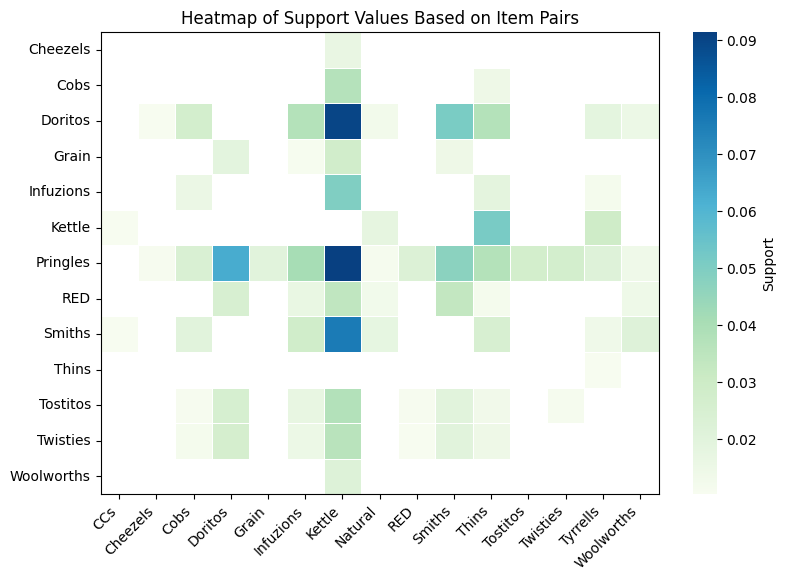

In [56]:
top_pairs['Item1']= top_pairs['itemsets'].apply(lambda x: list(x)[0])
top_pairs['Item2']= top_pairs['itemsets'].apply(lambda x: list(x)[1])


heatmap_data = pd.crosstab(top_pairs["Item1"], top_pairs["Item2"],values=top_pairs["support"], aggfunc="mean")

plt.figure(figsize=(9, 6))
sns.heatmap(heatmap_data, cmap="GnBu", annot=False, fmt=".1f", cbar_kws={'label':'Support'}, linewidths=0.5)
plt. title("Heatmap of Support Values Based on Item Pairs") 
plt.xticks(rotation=45, ha="right")
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.xlabel('')
plt.ylabel('')
plt.show()
  


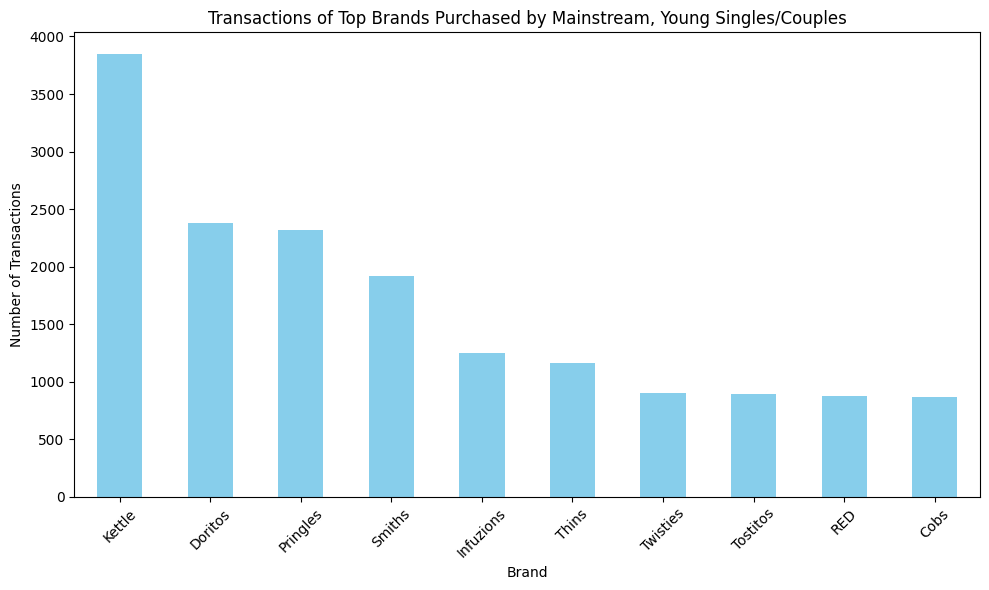

In [57]:
import matplotlib.pyplot as plt

# Filter for Mainstream, young singles/couples
target_segment = merged_df[
    (merged_df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') &
    (merged_df['PREMIUM_CUSTOMER'] == 'Mainstream')
]

# Count transactions per brand
brand_counts = target_segment['BRAND'].value_counts(ascending=False)

# Take top 10 brands
top_brands = brand_counts.head(10)

# Plot
plt.figure(figsize=(10,6))
top_brands.plot(kind='bar', color='skyblue')
plt.title("Transactions of Top Brands Purchased by Mainstream, Young Singles/Couples")
plt.ylabel("Number of Transactions")
plt.xlabel("Brand")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


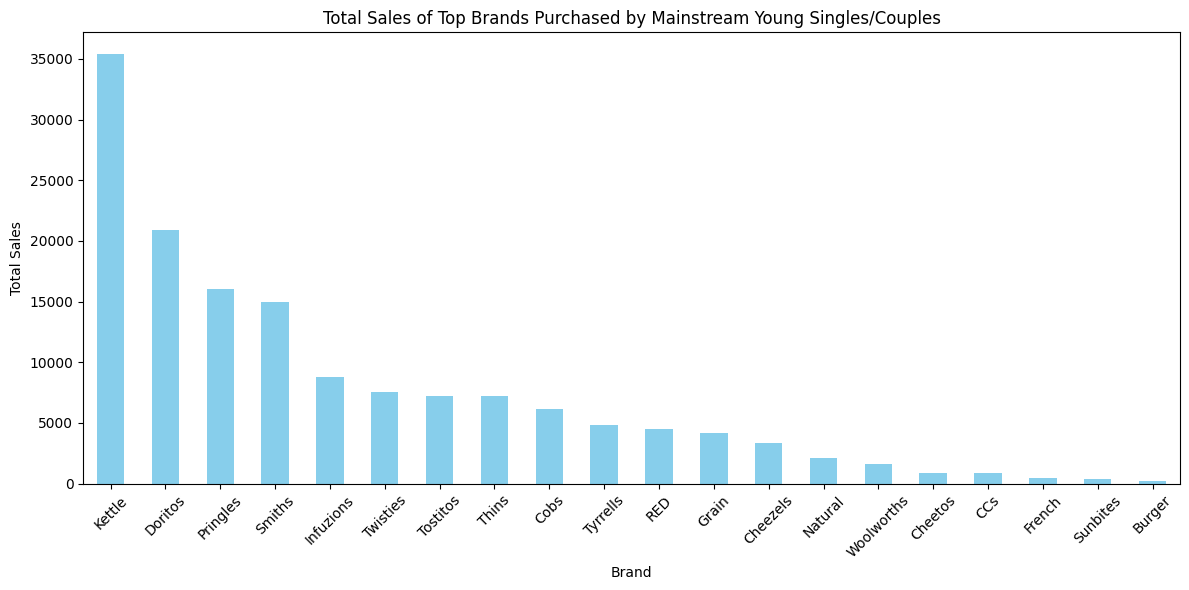

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter for Mainstream, young singles/couples
target_segment = merged_df[
    (merged_df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') &
    (merged_df['PREMIUM_CUSTOMER'] == 'Mainstream')
]

# Count total sales per brand
brand_sales = target_segment.groupby('BRAND')['TOT_SALES'].sum().sort_values(ascending=False)

# Plot side-by-side bar chart
plt.figure(figsize=(12,6))
brand_sales.plot(kind='bar', color='skyblue')
plt.xlabel('Brand')
plt.ylabel('Total Sales')
plt.title('Total Sales of Top Brands Purchased by Mainstream Young Singles/Couples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



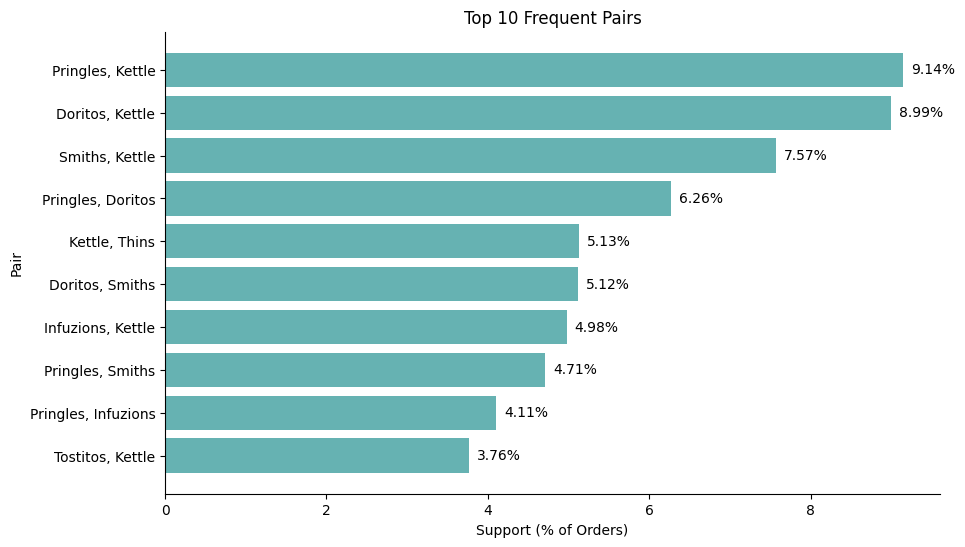

In [59]:
# Get top 10 2-item frequent itemsets sorted by support
top_pairs = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x) == 2)].sort_values(by="support", ascending=False).head (10)
top_pairs['itemsets'] = top_pairs['itemsets'].apply(lambda x: ', '.join(list(x)))
pairs = top_pairs['itemsets']
support_values = top_pairs['support']*100
plt.figure(figsize=(10, 6))
bars = plt.barh(pairs, support_values, color='#66b2b2')
for bar in bars:
    plt.text(bar.get_width()+ 0.1, bar.get_y()+bar.get_height()/2,
             f'{bar.get_width():.2f}%', va='center', ha='left', color='black', fontsize=10)
plt.xlabel('Support (% of Orders)')
plt.ylabel('Pair')
plt.title('Top 10 Frequent Pairs') 
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False) 
plt.gca().invert_yaxis()
plt.show()


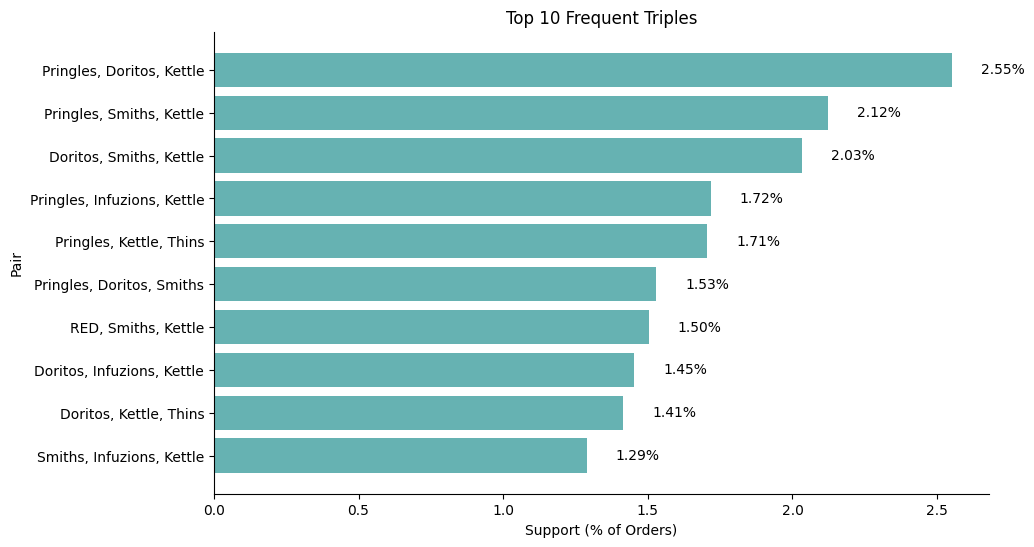

In [60]:
# Get top 10 2-item frequent itemsets sorted by support
top_pairs = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x) == 3)].sort_values(by="support", ascending=False).head (10)
top_pairs['itemsets'] = top_pairs['itemsets'].apply(lambda x: ', '.join(list(x)))
pairs = top_pairs['itemsets']
support_values = top_pairs['support']*100
plt.figure(figsize=(10, 6))
bars = plt.barh(pairs, support_values, color='#66b2b2')
for bar in bars:
    plt.text(bar.get_width()+ 0.1, bar.get_y()+bar.get_height()/2,
             f'{bar.get_width():.2f}%', va='center', ha='left', color='black', fontsize=10)
plt.xlabel('Support (% of Orders)')
plt.ylabel('Pair')
plt.title('Top 10 Frequent Triples') 
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False) 
plt.gca().invert_yaxis()
plt.show()


In [61]:
raw_rules = association_rules(frequent_itemsets, metric= "lift", min_threshold=1)

rules = raw_rules[['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support', 'confidence', 'lift']].sort_values(by="lift",ascending = False)
rules.head(5)

# antecedent support (all 9% orders has RED), consequent support(3% orders has Natural),
#support(all 1% orders has RED and Natural),
#confidence(11% Conditional probability that Naturals occur when RED is bought)
# lift (How likely does Natural appear when you have RED)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
45,(Natural),(RED),0.046482,0.093975,0.013136,0.282609,3.007276
44,(RED),(Natural),0.093975,0.046482,0.013136,0.139785,3.007276
62,(RED),(Woolworths),0.093975,0.053808,0.014273,0.151882,2.822647
63,(Woolworths),(RED),0.053808,0.093975,0.014273,0.265258,2.822647
181,"(Smiths, Kettle)",(Woolworths),0.075660,0.053808,0.010231,0.135225,2.513097


In [62]:
rules['rule'] = rules['antecedents'].apply(lambda x:','.join(sorted(x))) + " --> " + rules['consequents'].apply(lambda x: ', '.join(sorted(x)))
rules = rules[['rule'] + [col for col in rules.columns if col != 'rule']]
rules = rules.reset_index(drop=True)
rules

,rule,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
0,Natural --> RED,(Natural),(RED),0.046482,0.093975,0.013136,0.282609,3.007276
1,RED --> Natural,(RED),(Natural),0.093975,0.046482,0.013136,0.139785,3.007276
2,RED --> Woolworths,(RED),(Woolworths),0.093975,0.053808,0.014273,0.151882,2.822647
3,Woolworths --> RED,(Woolworths),(RED),0.053808,0.093975,0.014273,0.265258,2.822647
4,"Kettle,Smiths --> Woolworths","(Smiths, Kettle)",(Woolworths),0.075660,0.053808,0.010231,0.135225,2.513097
...,...,...,...,...,...,...,...,...
181,Infuzions --> Twisties,(Infuzions),(Twisties),0.143110,0.107364,0.015410,0.107679,1.002932
182,Grain --> Pringles,(Grain),(Pringles),0.078818,0.256158,0.020210,0.256410,1.000986
183,Pringles --> Grain,(Pringles),(Grain),0.256158,0.078818,0.020210,0.078895,1.000986
184,Cobs --> Doritos,(Cobs),(Doritos),0.103827,0.260326,0.027030,0.260341,1.000057


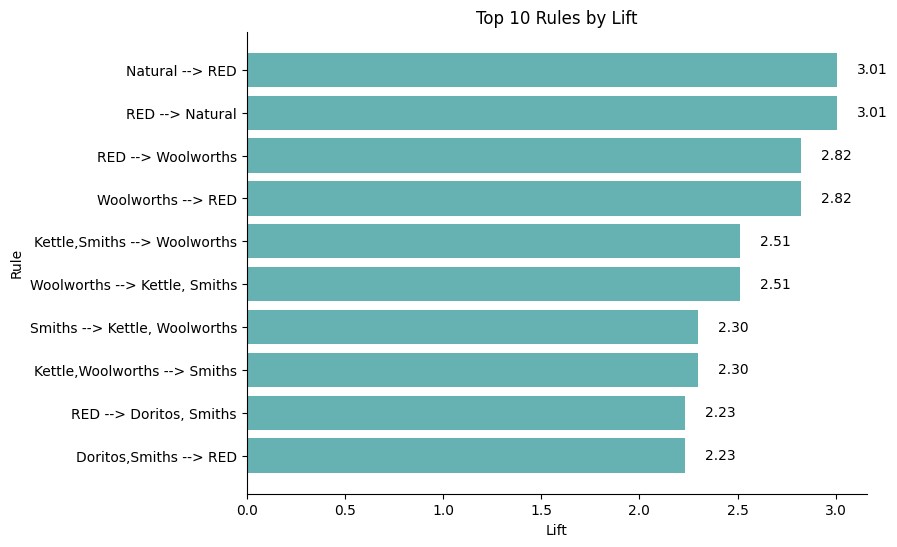

In [63]:
rule = rules['rule'].head(10)
lift_values = rules['lift'].head(10)
plt.figure(figsize=(8, 6))
bars = plt.barh(rule, lift_values, color='#66b2b2')
for bar in bars:
    plt.text(bar.get_width() + 0.1,bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f}', va='center', ha='left', color='black', fontsize=10)
plt.xlabel('Lift')
plt.ylabel('Rule')
plt.title('Top 10 Rules by Lift') 
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().invert_yaxis()
plt.show()

In [66]:
target_segment

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_WEIGH,PROD_WEIGH_NUM,WORDS,PROD_NAME_STR,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
221345,2018-08-16,1,1020,26,19,"[Smiths, Crinkle, Cut]",1,2.6,150g,150.0,"[Smiths, Crinkle, Cut, Snag&Sauce]",Smiths Crinkle Cut,Smiths,YOUNG SINGLES/COUPLES,Mainstream
221346,2018-08-17,1,1163,188,46,"[Kettle, Original]",1,5.4,175g,175.0,"[Kettle, Original]",Kettle Original,Kettle,YOUNG SINGLES/COUPLES,Mainstream
221347,2018-08-14,1,1291,333,27,"[WW, Supreme, Cheese, Corn, Chips]",1,1.9,200g,200.0,"[WW, Supreme, Cheese, Corn, Chips]",WW Supreme Cheese Corn Chips,Woolworths,YOUNG SINGLES/COUPLES,Mainstream
221348,2019-05-15,3,3031,1227,14,"[Smiths, Crnkle, Chip, Orgnl, Big, Bag]",1,5.9,380g,380.0,"[Smiths, Crnkle, Chip, Orgnl, Big, Bag]",Smiths Crnkle Chip Orgnl Big Bag,Smiths,YOUNG SINGLES/COUPLES,Mainstream
221349,2019-05-18,3,3118,1574,62,"[Pringles, Mystery, Flavour]",1,3.7,134g,134.0,"[Pringles, Mystery, Flavour]",Pringles Mystery Flavour,Pringles,YOUNG SINGLES/COUPLES,Mainstream
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240884,2018-12-01,272,272377,270186,75,"[Cobs, Popd, Sea, Salt, Chips]",2,7.6,110g,110.0,"[Cobs, Popd, Sea, Salt, Chips]",Cobs Popd Sea Salt Chips,Cobs,YOUNG SINGLES/COUPLES,Mainstream
240885,2018-07-27,272,272389,270200,114,"[Kettle, Sensations, Siracha, Lime]",2,9.2,150g,150.0,"[Kettle, Sensations, Siracha, Lime]",Kettle Sensations Siracha Lime,Kettle,YOUNG SINGLES/COUPLES,Mainstream
240886,2018-11-10,272,272389,270201,26,"[Pringles, BBQ]",2,7.4,134g,134.0,"[Pringles, Sweet&Spcy, BBQ]",Pringles BBQ,Pringles,YOUNG SINGLES/COUPLES,Mainstream
240887,2019-04-01,272,272389,270202,62,"[Pringles, Mystery, Flavour]",2,7.4,134g,134.0,"[Pringles, Mystery, Flavour]",Pringles Mystery Flavour,Pringles,YOUNG SINGLES/COUPLES,Mainstream


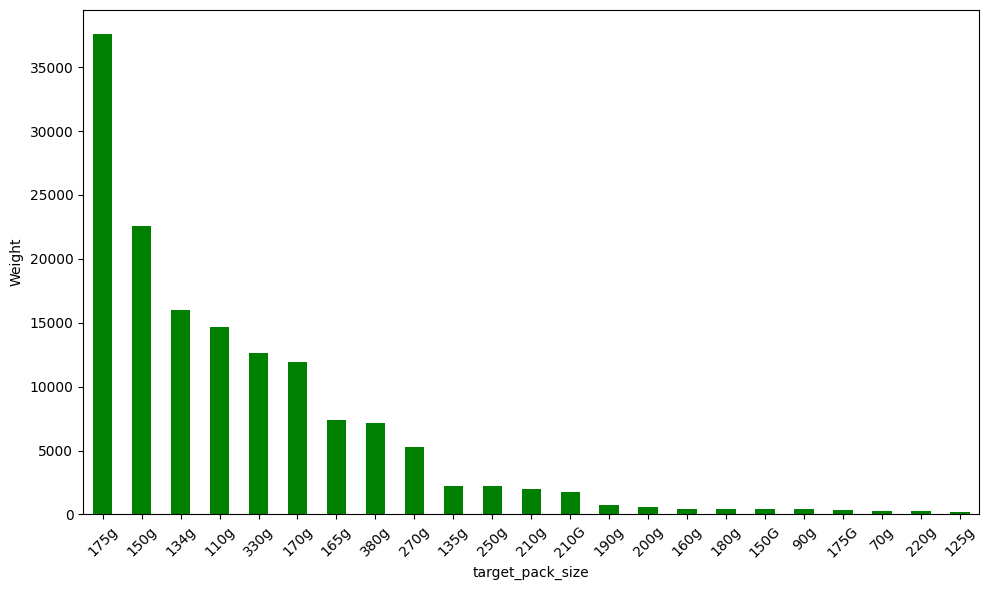

PROD_WEIGH
175g    37595.9
150g    22552.0
134g    16006.2
110g    14630.0
330g    12654.0
Name: TOT_SALES, dtype: float64

In [67]:
target_pack_size = target_segment.groupby('PROD_WEIGH')['TOT_SALES'].sum().sort_values(ascending = False)

plt.figure(figsize=(10,6))
target_pack_size.plot(kind= 'bar', color = 'green')
plt.xlabel('target_pack_size')
plt.ylabel('Weight')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
target_pack_size.head(5)

#### 175 g is the preferred pack size of the target segment 

# Conclusion

This analysis results showed that sales are primarily driven by Budget – Older Families, Mainstream – Young Singles/Couples, and Mainstream – Midage Singles/Couples shoppers.

The higher chip spend among Mainstream Young Singles/Couples and retirees is largely due to the higher number of customers within these segments compared to others.

Mainstream midage and young singles and couples are also more likely to pay more per packet of chips, which may indicate more impulse-driven purchasing behaviour.

Used p-value calculation and found statistically significant TOT_SALES difference (pval < 5%) between "Mainstream Young Midage" to "Budget and Premium Young Midage" segment.

Additionally, Mainstream Young Singles and Couples are more likely to purchase Tyrrells chips compared to the rest of the population. The Category Manager could consider increasing category performance by off-locating Tyrrells and smaller chip pack sizes in discretionary spaces where young singles and couples are more likely to shop, helping improve visibility and encourage impulse purchases.

we can support the Category Manager by identifying where these customer segments are most likely to shop, measuring the impact of placement changes, and providing promotional recommendations such as “Buy 2, Get 1 Free” offers to further increase sales and  measure the impact of trials.